In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
# Standard Python imports
import random
from functools import partial

import gpflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Trieste imports
import trieste
from trieste.acquisition import ExpectedImprovement
from trieste.acquisition.rule import OBJECTIVE
from trieste.data import Dataset
from trieste.experimental.plotting import plot_function_2d
from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.objectives import Branin, ScaledBranin, SingleObjectiveTestProblem
from trieste.objectives.utils import mk_observer

# Local imports
from online_neuro.bayessian_optimizer import AskTellOptimizerHistory

2025-12-18 14:07:13.868274: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 14:07:13.870922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 14:07:13.901966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 14:07:13.903702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 14:07:14.612960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Branin Regression
This notebook runs and visualize Bayesian optimization on the Scaled Branin test problem (deterministic and noisy variants) using GPflow and Trieste.
Main focus is to observe rate of convergence under noisy scenarios. 

In [4]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

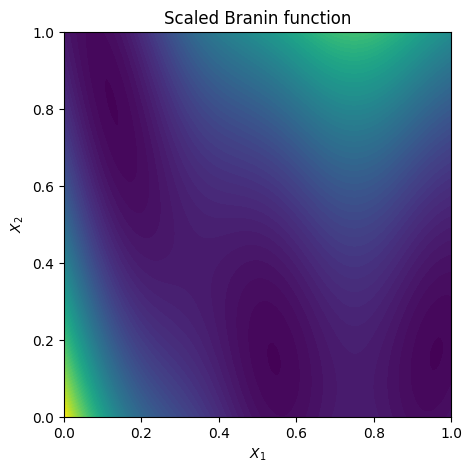

In [5]:
scaled_branin = ScaledBranin.objective
search_space = ScaledBranin.search_space

# Define the objective function
def objective(x):
    return tf.reshape(scaled_branin(x), (-1, 1))

# Generate initial data
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points)
initial_data = Dataset(initial_query_points, initial_observations)

gpflow_model = build_gpr(initial_data,
                         search_space=search_space, 
                         kernel=gpflow.kernels.Matern52(),
                         likelihood_variance=1e-5)

model = GaussianProcessRegression(gpflow_model)
_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Scaled Branin function"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plt.show()


In [6]:
model.update(initial_data)
model.optimize(initial_data)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.8219678240614163
        x: [-1.704e+00 -1.163e+00 -1.272e-01]
      nit: 15
      jac: [-3.521e-06 -4.835e-07 -1.403e-05]
     nfev: 20
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [7]:
ei = ExpectedImprovement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(ei)  # type: ignore
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(mk_observer(scaled_branin), search_space)
results = bo.optimize(num_steps, initial_data, model, rule)

Optimization completed without errors


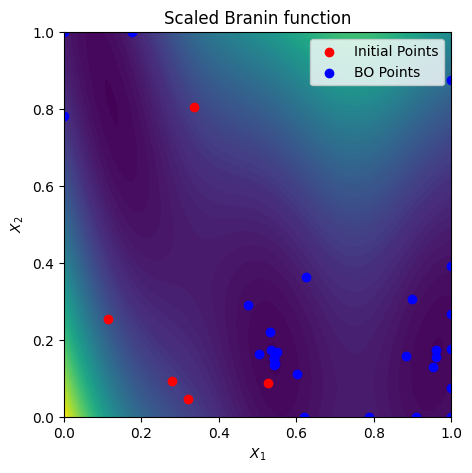

In [8]:
final_dataset = results.try_get_final_datasets()[OBJECTIVE]
final_model = results.try_get_final_models()[OBJECTIVE]

_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Scaled Branin function"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)

plt.scatter(initial_data.query_points[:,0], initial_data.query_points[:,1], c='red', label="Initial Points")
plt.scatter(final_dataset.query_points[num_initial_points:,0], final_dataset.query_points[num_initial_points:,1], c='blue', label="BO Points")
plt.legend()

Text(0.5, 1.0, 'Observations over BO iterations')

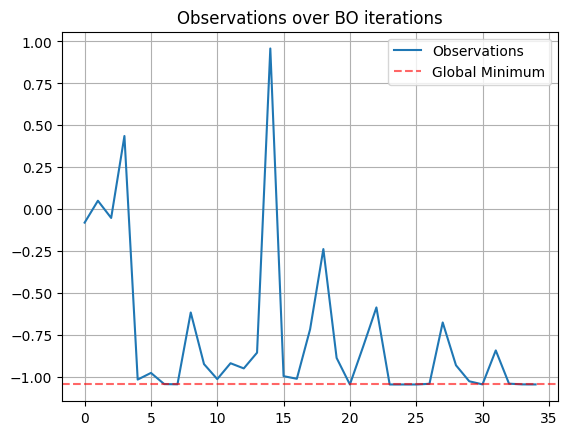

In [9]:
plt.plot(final_dataset.observations, label="Observations")
plt.axhline(ScaledBranin.minimum, c='r',alpha=0.6, linestyle='--', label='Global Minimum')
plt.grid()
plt.legend()
plt.title("Observations over BO iterations")

## A Branin With Gaussian Noise

In [10]:
def noisy_scaled_branin(x: tf.Tensor, variance) -> tf.Tensor:
    """Noisy version of the Scaled Branin function."""

    noise = tf.random.normal(shape=tf.shape(x)[:-1], mean=0.0, stddev=tf.sqrt(tf.cast(variance, x.dtype)), dtype=x.dtype)
    return tf.reshape(ScaledBranin.objective(x), (-1,)) + noise


In [11]:
noise_variance = 0.001
noise_std = np.sqrt(noise_variance)
x_test = tf.constant([[0.25, 0.75], [0.5, 0.5], [0.9, 0.1]], dtype=tf.float64)

# 1. Instantiate the original, deterministic ScaledBranin
branin_deterministic = ScaledBranin
y_true = branin_deterministic.objective(x_test)
true_std = np.ones(3)*noise_std

print("--- Deterministic ScaledBranin ---")
print(f"Test points:\n{x_test.numpy()}")
print(f"Objective values:\n{y_true.numpy()}\n")

# 2. Instantiate the new noisy version with a specified noise variance
Branin_Noisy = SingleObjectiveTestProblem(
    name = "NoisyScaledBranin",
    objective = partial(noisy_scaled_branin, variance=noise_variance),
    search_space=Branin.search_space,
    minimizers=Branin.minimizers,
    minimum=tf.constant([-1.047393], tf.float64)
)

# 3. Evaluate the noisy objective at the same points
noisy_observations = []

for _ in range(50):
    noisy_observations.append(Branin_Noisy.objective(x_test).numpy())

noisy_observations = np.stack(noisy_observations)
mean = np.mean(noisy_observations, axis=0)
variance = np.var(noisy_observations, axis=0)
columns = ['Feature A', 'Feature B', 'Feature C']

feature_to_x = {feature: i for i, feature in enumerate(columns)}



--- Deterministic ScaledBranin ---
Test points:
[[0.25 0.75]
 [0.5  0.5 ]
 [0.9  0.1 ]]
Objective values:
[[-0.62418706]
 [-0.59056854]
 [-0.97203677]]



/tmp/ipykernel_97013/1352559424.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Observation', y='Value', data=df_long, inner='box', palette='Set1')


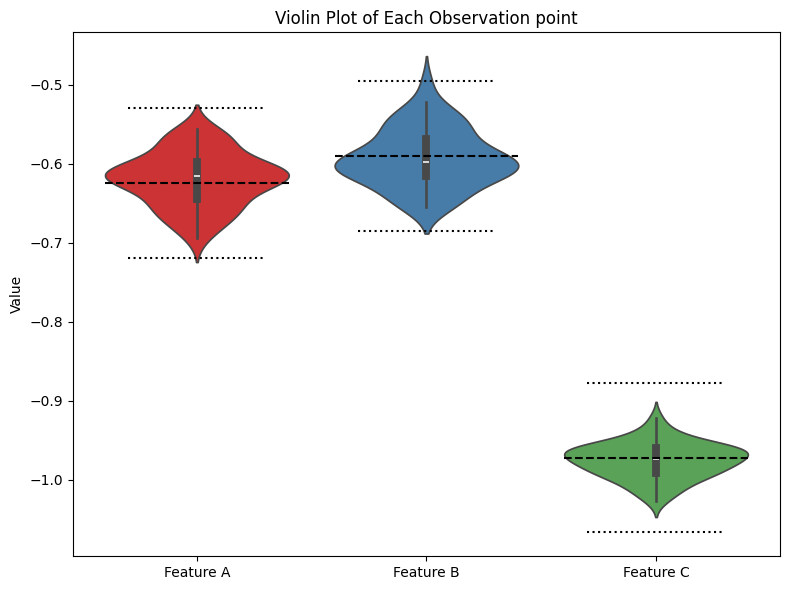

In [12]:
df = pd.DataFrame(noisy_observations, columns=columns)
df_long = df.melt(var_name='Observation', value_name='Value')

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Observation', y='Value', data=df_long, inner='box', palette='Set1')

for feature, mean, std in zip(columns, y_true, true_std):
    x_pos = feature_to_x[feature]
    # Mean line
    plt.hlines(mean, x_pos - 0.4, x_pos + 0.4, colors='black', linestyles='--', label='True Mean' if x_pos == 0 else "")
    # Std deviation lines (optional)
    plt.hlines([mean - 3*std, mean + 3*std], x_pos - 0.3, x_pos + 0.3, colors='black', linestyles=':', label='±3 Std Dev' if x_pos == 0 else "")


# Title and labels
plt.title("Violin Plot of Each Observation point")
plt.xlabel("")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

## Optimizing Noisy Branin without learning noise variance

In [13]:
scaled_branin_noisy = Branin_Noisy.objective
search_space = Branin_Noisy.search_space

# Define the objective function
def objective(x):
    return tf.reshape(scaled_branin_noisy(x), (-1, 1))

# Generate initial data
num_initial_points = 10
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points)
initial_data = Dataset(initial_query_points, initial_observations)


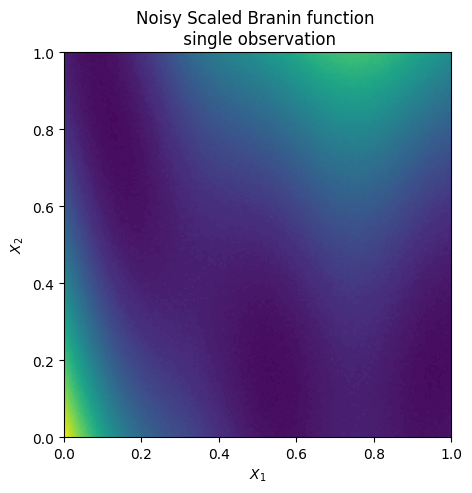

In [14]:

gpflow_model = build_gpr(initial_data,
                         search_space=search_space, 
                         kernel=gpflow.kernels.Matern52(),
                         trainable_likelihood=False,
                         likelihood_variance=1e-5)

model = GaussianProcessRegression(gpflow_model)

_, ax = plot_function_2d(
    scaled_branin_noisy,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Noisy Scaled Branin function \n single observation"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plt.show()


In [15]:
ei = ExpectedImprovement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(ei)
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(mk_observer(objective), search_space)
results = bo.optimize(num_steps, initial_data, model, rule)

Optimization completed without errors


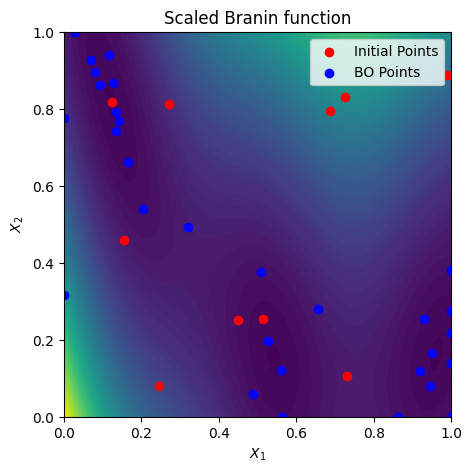

In [16]:
final_dataset = results.try_get_final_datasets()[OBJECTIVE]
final_model = results.try_get_final_models()[OBJECTIVE]

_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Scaled Branin function"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)

plt.scatter(initial_data.query_points[:,0], initial_data.query_points[:,1], c='red', label="Initial Points")
plt.scatter(final_dataset.query_points[num_initial_points:,0], final_dataset.query_points[num_initial_points:,1], c='blue', label="BO Points")
plt.legend()

Text(0.5, 1.0, 'Observations over BO iterations')

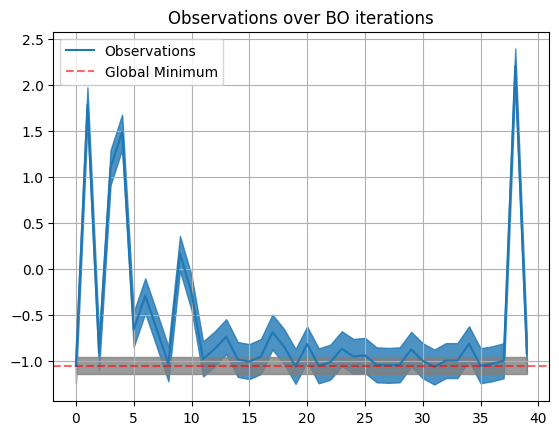

In [17]:
num = 3

plt.plot(final_dataset.observations, label="Observations",color='C0')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 (final_dataset.observations - num * noise_std).numpy().squeeze() - num * noise_std, 
                 (final_dataset.observations + num * noise_std).numpy().squeeze() + num * noise_std, 
                 color='C0', alpha=0.8)

plt.axhline(ScaledBranin.minimum, c='r',alpha=0.6, linestyle='--', label='Global Minimum')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 ScaledBranin.minimum - num * noise_std, ScaledBranin.minimum + num * noise_std, 
                 color='gray', alpha=0.8)


plt.grid()
plt.legend()
plt.title("Observations over BO iterations")

## Optimizing Noisy Braning and learning noise variance

In [18]:
gpflow_model = build_gpr(initial_data,
                         search_space=search_space, 
                         kernel=gpflow.kernels.Matern52(),
                         trainable_likelihood=True,
                         likelihood_variance=1e-5)

model = GaussianProcessRegression(gpflow_model)


In [19]:
ei = ExpectedImprovement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(ei)
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(mk_observer(objective), search_space)
results = bo.optimize(num_steps, initial_data, model, rule)

Optimization completed without errors


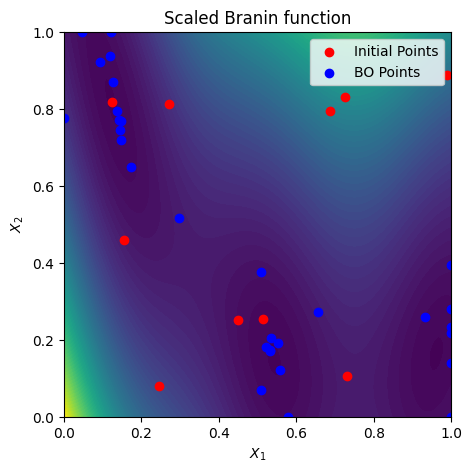

In [20]:
final_dataset = results.try_get_final_datasets()[OBJECTIVE]
final_model = results.try_get_final_models()[OBJECTIVE]

_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Scaled Branin function"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)

plt.scatter(initial_data.query_points[:,0], initial_data.query_points[:,1], c='red', label="Initial Points")
plt.scatter(final_dataset.query_points[num_initial_points:,0], final_dataset.query_points[num_initial_points:,1], c='blue', label="BO Points")
plt.legend()

Text(0.5, 1.0, 'Observations over BO iterations')

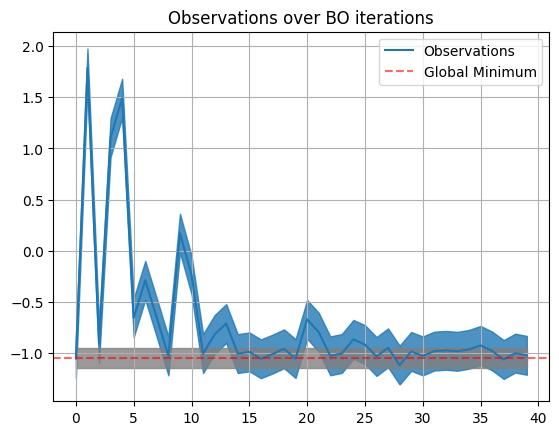

In [21]:
num = 3
plt.plot(final_dataset.observations, label="Observations",color='C0')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 (final_dataset.observations - num * noise_std).numpy().squeeze() - num * noise_std, 
                 (final_dataset.observations + num * noise_std).numpy().squeeze() + num * noise_std, 
                 color='C0', alpha=0.8)

plt.axhline(ScaledBranin.minimum, c='r',alpha=0.6, linestyle='--', label='Global Minimum')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 ScaledBranin.minimum - num * noise_std, ScaledBranin.minimum + num * noise_std, 
                 color='gray', alpha=0.8)


plt.grid()
plt.legend()
plt.title("Observations over BO iterations")

## Solving the same problem with the Ask-Tell interface (explict 1-step at a time)

In [22]:
gpflow_model = build_gpr(initial_data,
                         search_space=search_space, 
                         kernel=gpflow.kernels.Matern52(),
                         trainable_likelihood=True,
                         likelihood_variance=1e-5)

model = GaussianProcessRegression(gpflow_model)
ei = ExpectedImprovement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(ei)
num_steps = 30
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=initial_data,
                                   models=model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )



In [23]:
observations = []
for step in range(num_steps):
    print(f"Iteration {step+1}/{num_steps}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    if qp.ndim==1:
        qp = qp.reshape(-1, 1)
        
    observation = objective(qp)
    observations.append(observation.numpy())

    tagged_output = {"OBJECTIVE": Dataset(tf.cast(qp, tf.float64),
                                          tf.cast(observation, tf.float64))
                     }
    ask_tell.tell(tagged_output)   

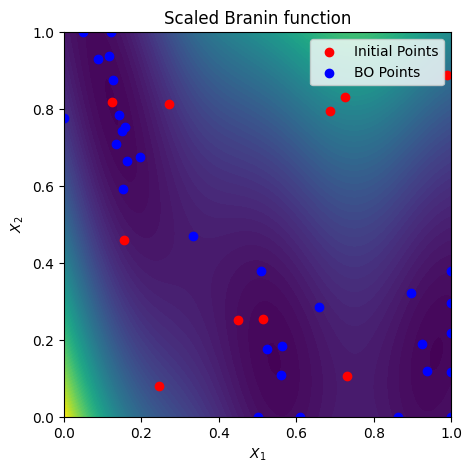

In [24]:
final_dataset = ask_tell.datasets[OBJECTIVE]
final_model = ask_tell.models[OBJECTIVE]

_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(5, 5),
    title=["Scaled Branin function"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)

plt.scatter(initial_data.query_points[:,0],
            initial_data.query_points[:,1], c='red', label="Initial Points")
plt.scatter(final_dataset.query_points[num_initial_points:,0], 
            final_dataset.query_points[num_initial_points:,1], c='blue', label="BO Points")
plt.legend()

Text(0.5, 1.0, 'Observations over BO iterations')

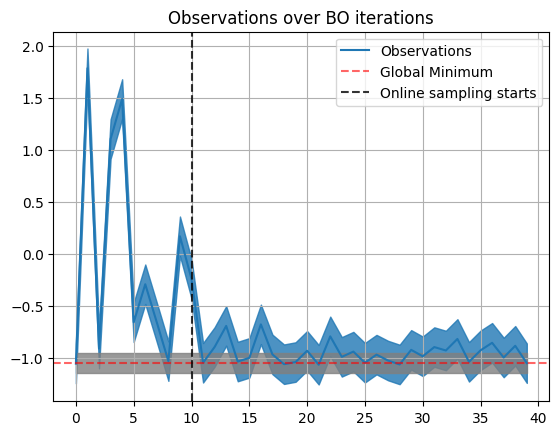

In [25]:
num = 3
plt.plot(final_dataset.observations, label="Observations",color='C0')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 (final_dataset.observations - num * noise_std).numpy().squeeze() - num * noise_std, 
                 (final_dataset.observations + num * noise_std).numpy().squeeze() + num * noise_std, 
                 color='C0', alpha=0.8)

plt.axhline(ScaledBranin.minimum, c='r',alpha=0.6, linestyle='--', label='Global Minimum')
plt.fill_between(np.arange(len(final_dataset.observations)),
                 ScaledBranin.minimum - num * noise_std, ScaledBranin.minimum + num * noise_std, 
                 color='gray', alpha=0.8)

plt.axvline(num_initial_points, c='k', alpha=0.8, linestyle='--', label="Online sampling starts")

plt.grid()
plt.legend()
plt.title("Observations over BO iterations")